# Imports

In [24]:
# System
import os
from os.path import join, basename, dirname, exists

# For submission
import csv
import copy

# Computational
import numpy as np
import pandas as pd
import ast

# Images and augmentation
from scipy.ndimage import imread
from imgaug import augmenters as iaa

# Analysis and plots
from collections import Counter
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
%matplotlib inline

# Deep learning
import keras
from keras import backend as K

# Pre-trained models imports
from keras.applications import vgg16, xception

# Preprocessing imports
from keras.applications.imagenet_utils import decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Layer imports
from keras.layers import Flatten, Dense
from keras import Model

# Probably not needed anymore?
from sklearn.metrics import fbeta_score

data_dir = "D:/MLiP/data/"

# Handy functions

In [2]:
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    # image = np.interp(image, [np.min(image), np.max(image)], [range_min, range_max])

    return image

In [3]:
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

In [4]:
def get_samples_containing_label(df, label):
    
    # create list of imageIds of images that have label in their labelId list
    label_idx = []
    for row in df:
        if label in row['labelId']:
            label_idx.append(row['imageId'])
            
    # return dataframe 
    return df['imageId'].isin(label_idx)

In [5]:
def labels_one_hot(labels):
    
    onehot_label = [0.] * 228
    for label in labels:
        onehot_label[int(label) - 1] = 1.
    
    return onehot_label

In [6]:
def basic_augmentation(image): # Used for the BatchGenerator
    
    # More (simple) augmenters can be added
    aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Scale({"height": 299, "width": 299})
#         iaa.Affine(rotate=(-10, 10)),
#         iaa.GaussianBlur(sigma=(0.0, 0.5)),
    ])
    
    image = aug.augment_images([image])[0] / 255
    
    return image

# Generator / Sequences

In [22]:
class BatchGenerator(object):

    def __init__(self, input_dir, csv_path, batch_size, augmentation_fn=basic_augmentation):

        # Params
        self.input_dir = input_dir  # path to images
        self.csv_path = csv_path  # path to CSV
        self.batch_size = batch_size  # number of images per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.batch_size
        
        # Print some info
        print('BatchGenerator detected: {n_samples} image samples.'.format(n_samples=self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch

        # Randomly sample from the dataframe
        df_batch = self.df.sample(self.batch_size)
        
        # Drop sampled images from dataframe ()
        self.df = self.df.drop(df_batch.index)
        
        # We might want to sample specific labels later on: get_samples_containing_label() ?

        # Iterate over selected images 
        images = []
        labels = []
        for idx, row in df_batch.iterrows():

            try:

                # Read image path
                img_id = row['imageId']
                image_path = self.input_dir + "/" + str(img_id) + ".jpg"

                # Read data and label
                image = load_image(image_path)
                label = labels_one_hot(ast.literal_eval(row['labelId']))

                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                images.append(image)
                labels.append(label)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))
            
        # Assemble batch
        batch_x = np.array(images)
        batch_y = np.array(labels)

        return batch_x, batch_y

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



BatchGenerator detected: 1014544 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

`imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.



(32, 299, 299, 3)
(32, 228)


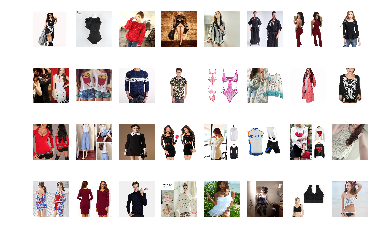

In [23]:
# Test the generator
training_gen = BatchGenerator(
    input_dir = join(data_dir, "train/"),
    csv_path = join(data_dir, "csv/train_labels.csv"),
    batch_size = 32,
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

In [9]:
class BatchSequence(keras.utils.Sequence):

    def __init__(self, input_dir, csv_path, batch_size):

        # Params
        self.input_dir = input_dir  # path to images
        self.csv_path = csv_path  # path to CSV
        self.batch_size = batch_size  # number of images per batch
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Length
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('BatchSequence detected: {n_samples} image samples.'.format(n_samples=len(self.df)))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        labels = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                # Read image path
                row = self.df.iloc[i, :]
                img_id = row['imageId']
                image_path = self.input_dir + "/" + str(img_id) + ".jpg"
                
                # Read data and label
                image = load_image(image_path)
                label = labels_one_hot(ast.literal_eval(row['labelId']))

                resize_aug = iaa.Scale({"height": 299, "width": 299})
                image = resize_aug.augment_images([image])[0] / 255
                
                # Append
                images.append(image)
                labels.append(label)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))

        # Assemble batch            
        batch_x = np.array(images)
        batch_y = np.array(labels)

        return batch_x, batch_y

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


BatchSequence detected: 9897 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


(32, 299, 299, 3)
(32, 228)


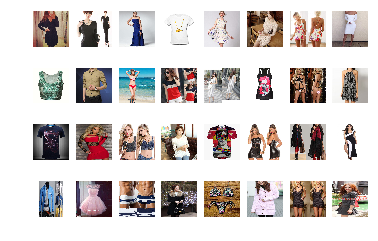

In [10]:
# Test the sequence
validation_seq = BatchSequence(
    input_dir = join(data_dir, 'validation/'),
    csv_path = join(data_dir, "csv/valid_labels.csv"),
    batch_size=32
)

for batch_x, batch_y in validation_seq:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

In [13]:
class TestSequence(keras.utils.Sequence):

    def __init__(self, input_dir, batch_size):

        # Params
        self.input_dir = input_dir  # path to images
        self.batch_size = batch_size  # number of images per batch
        
        # Length
        self.n_samples = 39706
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('TestSequence detected: {n_samples} image samples.'.format(n_samples=self.n_samples))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                img_id = i + 1
                
                # Read image path
                image_path = self.input_dir + str(img_id) + ".jpg"
                
                # Read data and label
                image = load_image(image_path)

                resize_aug = iaa.Scale({"height": 299, "width": 299})
                image = resize_aug.augment_images([image])[0] / 255
                
                # Append
                images.append(image)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))
                print(e)

        # Assemble batch            
        batch_x = np.array(images)

        return batch_x

TestSequence detected: 39706 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


(32, 299, 299, 3)


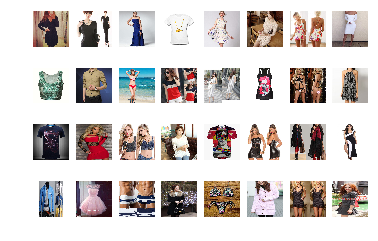

In [15]:
# Test the sequence
test_seq = TestSequence(
    input_dir = join(data_dir, 'test/'),
    batch_size=32
)

for batch_y in test_seq:
    print(batch_x.shape)
    plot_image(batch_x, images_per_row=8)
    break

# Deep learning

In [16]:
# F-beta score has been removed from keras. Re-implementation found on StackOverflow
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [17]:
num_classes = 228

# Setup models
base_xception_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x_xception = base_xception_model.output
x_xception = Flatten()(x_xception)
x_xception = Dense(128, activation='relu')(x_xception)
predictions_xception = Dense(num_classes, activation='sigmoid')(x_xception)

model_xception = Model(inputs=base_xception_model.input, outputs=predictions_xception)

for layer in base_xception_model.layers[:120]:
    layer.trainable = False
for layer in base_xception_model.layers[120:]:
    layer.trainable = True

model_xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])
logger_xception = ModelCheckpoint('xception_checkpoint.hdf5', monitor='val_fbeta', verbose=1, save_best_only=True, mode='max')

model_xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [16]:
# Parameters
batch_size = 32
steps_per_epoch = 1500
epochs = 21

# Training generator
training_gen = BatchGenerator(
    input_dir = join(data_dir, "train/"),
    csv_path = join(data_dir, "csv/train_labels.csv"),
    batch_size = batch_size,
    augmentation_fn = basic_augmentation
)

# Validation sequence
validation_seq = BatchSequence(
    input_dir = join(data_dir, 'validation/'),
    csv_path = join(data_dir, "csv/valid_labels.csv"),
    batch_size = batch_size
)

# Train the model
history = model_xception.fit_generator(
    generator = training_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_seq,
    callbacks = [logger_xception],
)

BatchGenerator detected: 1014544 image samples.
BatchSequence detected: 9897 image samples.
Epoch 1/21


C:\Users\laure\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


1500/1500 [==============================] - 2056s 1s/step - loss: 0.0683 - fbeta: 0.3201 - val_loss: 0.0974 - val_fbeta: 0.3017
Epoch 2/21
1500/1500 [==============================] - 2273s 2s/step - loss: 0.0623 - fbeta: 0.3702 - val_loss: 0.0934 - val_fbeta: 0.3078
Epoch 3/21
1500/1500 [==============================] - 1877s 1s/step - loss: 0.0602 - fbeta: 0.3877 - val_loss: 0.0934 - val_fbeta: 0.3219
Epoch 4/21
1500/1500 [==============================] - 2080s 1s/step - loss: 0.0588 - fbeta: 0.3997 - val_loss: 0.0892 - val_fbeta: 0.3535
Epoch 5/21
1500/1500 [==============================] - 2027s 1s/step - loss: 0.0583 - fbeta: 0.4053 - val_loss: 0.0877 - val_fbeta: 0.3470
Epoch 6/21
1500/1500 [==============================] - 1965s 1s/step - loss: 0.0573 - fbeta: 0.4142 - val_loss: 0.0887 - val_fbeta: 0.3304
Epoch 7/21
1500/1500 [==============================] - 1953s 1s/step - loss: 0.0568 - fbeta: 0.4193 - val_loss: 0.0899 - val_fbeta: 0.3507
Epoch 8/21
1500/1500 [=========

# Prediction

In [35]:
# Load the best weights
model_xception.load_weights('xception_checkpoint_128fc.hdf5')

# Define test sequence
test_seq = TestSequence(
    input_dir = join(data_dir, 'test/'),
    batch_size = batch_size,
)

# Predict labels
predictions = model_xception.predict_generator(
    generator = test_seq,
    verbose = 1,
)

TestSequence detected: 39706 image samples.


C:\Users\laure\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


1241/1241 [==============================] - 1541s 1s/step


In [14]:
# Threshold should be chosen such that every image has at least one label
th = 0.314

# Treshold predictions
thresholded = copy.copy(predictions)
thresholded[thresholded >= th] = 1
thresholded[thresholded < th] = 0

# Should print 0 when thresholded correctly
zeros = 0
for pred in thresholded:
    if sum(pred) < 1:
        zeros += 1

print("Number of images without a label:", zeros)

In [54]:
# Make the submission in correct Kaggle format
with open('submission.csv', 'w') as file:
    file.write('image_id,label_id\n')
    for i, row in enumerate(thresholded):
        rowstr = str(i+1) + ','
        for i, prediction in enumerate(row):
            if prediction == 1:
                rowstr += str(i+1) + ' '
        file.write(rowstr[:-1] + '\n')

# Analysis
To be compared with the explorative data analysis notebook found in the Kaggle discussions.

In [15]:
# Open submission
label_df = pd.DataFrame.from_csv('submission.csv')

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [99]:
test = label_df['label_id'].tolist()
flatlabels = [x for sublist in test for x in sublist.split(' ')]

# Basic statistics
print("Total Images in the test:", len(test))
print("Total Labels in the test:", len(set(flatlabels)))
print("Average Labels in the test:", len(flatlabels) / len(test))

Total Images in the test: 39706
Total Labels in the test: 165
Average Labels in the test: 5.34987155593613


In [88]:
# Distribution of labels
test_labels = Counter(flatlabels)

xvalues = list(test_labels.keys())
yvalues = list(test_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="year count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the test dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [89]:
# Most common labels 
temps = test_labels.most_common(10)
labels_tr = ["Label-"+str(x[0]) for x in temps]
values = [x[1] for x in temps]

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=400, title='Top 10 Labels in the test dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [98]:
# Frequency distribution
nonflatlist = [x.split(' ') for x in test]
lbldst = Counter([len(x) for x in nonflatlist])

labels = list(lbldst.keys())
values = list(lbldst.values())

trace1 = go.Bar(x=labels, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(10, 80, 190, 0.8)'))
layout = dict(height=400, title='Frequency distribution of images with respective labels counts ', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);